# 4 ReactomeSuperPathwaysDrivers - Attack

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import glob
import numpy as np
import pickle 
import statistics as st
import random as rd

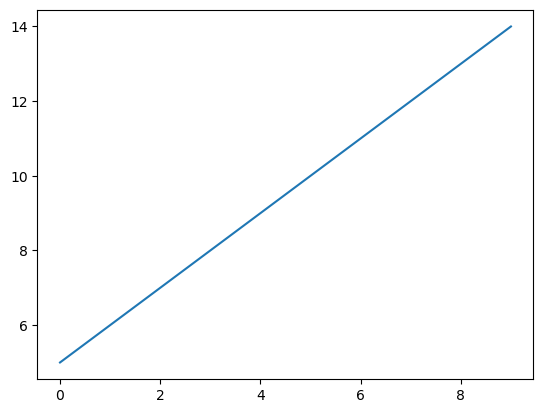

In [31]:
l1=[x for x in range(5,15)]
plt.plot(l1)
plt.show()

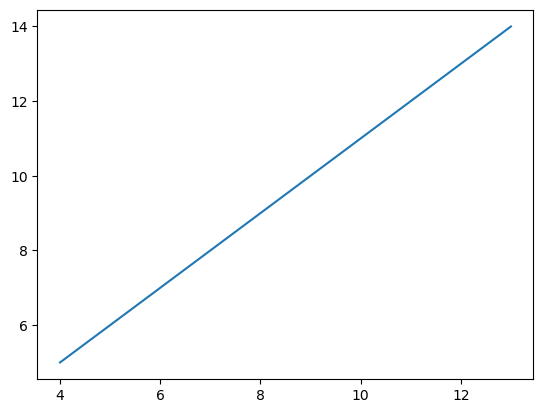

In [33]:
l1=[x for x in range(5,15)]
l2=[x for x in range(4,14)]
plt.plot(l2,l1)
plt.show()

In [2]:
class SuperPathwayClass:
    def __init__(self, name,idPathway,geneSet,networkWithCCs,networkLCC,drivers):
        self.name = name
        self.idPathway = idPathway
        self.geneSet = geneSet
        self.networkCCs = networkWithCCs
        self.networkLCC = networkLCC
        self.drivers = drivers
        self.topologicalFeaturesLCC = None
        self.layout_LCC_kamada_kawai= None
        self.layout_CCs_spring = None
        
    def info(self):
        info={}
        info['Name'] = self.name
        info['idPathway'] = self.idPathway        
        info['lenSet'] = len(self.geneSet)
        info['lenCCs'] = str(len(self.networkCCs.nodes)) +' ('+str(round(len(self.networkCCs.nodes)/len(self.geneSet)*100))+'%)'
        info['lenLCC'] = str(len(self.networkLCC.nodes)) +' ('+str(round(len(self.networkLCC.nodes)/len(self.geneSet)*100))+'%)'       
        driversLen = len(self.drivers)
        info['driversLCC'] = driversLen
        info['drivers %'] = round(driversLen/len(self.networkLCC.nodes)*100)
        
        return info  
        

In [3]:
def getErrorWraper(mr):
    return (getErroSTD(mr))

In [4]:
def getErrorMinMax(mr):
    results=[r[1] for r in mr]
    resultsUpper=[]
    resultsLower=[]
    
    numberOfColumns = len(results[0])
    for col in range(numberOfColumns):
        colValues=[]
        for line in results:
            colValues.append(line[col])
         
        resultsUpper.append(max(colValues)-np.mean(colValues))
        resultsLower.append(np.mean(colValues)-min(colValues))
        
    return resultsLower,resultsUpper

In [5]:
def getErroSTD(mr):
    #Calculate the variance.
    results=[r[1] for r in mr]
    resultsVariance=[]
    #results is a matriz. Each line is a repetion that contains 'howMany' values
    #The columns in this matriz are the values found in a point in time (f). So we the variance for each point 
    numberOfColumns = len(results[0])
    for col in range(numberOfColumns):
        colValues=[]
        for line in results:
            colValues.append(line[col])
        resultsVariance.append(np.std(colValues))   
    return resultsVariance

In [6]:
targetPathways = ['Circadian Clock','Reproduction','Programmed Cell Death','Chromatin Organization','DNA Repair','Developmental Biology','Gene Expression','ReactomeFI_LCC_AllSuperPathways']
file = open("2 output/superPathwaysObjs.pkl", "rb")
superPathwaysObjs = pickle.load(file)

In [7]:
superPathwaysObjs['Chromatin Organization']=superPathwaysObjs['Chromatin organization']
superPathwaysObjs['Gene Expression']=superPathwaysObjs['Gene expression (Transcription)']

#### Set how many times the attack is repeated

In [8]:
repeat=100

In [9]:
def plotDriverAttack(G_original,listOfDrivers):
    matrizOfResults=[]
    for _ in range(repeat):
        G = G_original.copy()
        Nstart = G.number_of_nodes()
        yAxis=[1]
        xAxis=[0]
        listOfNode = list(listOfDrivers)
        rd.shuffle(listOfNode)#Randomize the nodes
        for i,_ in enumerate(listOfNode):
            G.remove_node(listOfNode[i])
            Nactual = G.number_of_nodes()
            CCs = nx.connected_components(G)
            if Nactual != 0:
                LCC = max(CCs,key=len)
                #𝑃∞(𝑓)/𝑃∞(0)  = len(LCC)/Nstart # Because we start with a connect network, with only one connect component
                impact = len(LCC)/Nstart
            else:
                impact = 0 
            f = 1 - Nactual/Nstart
            yAxis.append(impact)
            xAxis.append(f)
            
        matrizOfResults.append([np.array(xAxis),np.array(yAxis)])
        
    y = np.array(matrizOfResults[0][1])
    for ex in matrizOfResults:
        y+=ex[1]
    y=y/(repeat+1)    
    
    error=getErrorWraper(matrizOfResults)

    plt.errorbar(xAxis,y,label='Drivers', yerr=error, ecolor='lightcoral', elinewidth=1, capsize=0,fmt='-',color='red',linewidth=2)


In [10]:
def plotRandomAttack(G_original,howMany):
    matrizOfResults=[]
    for _ in range(repeat):
        G = G_original.copy()
        Nstart = G.number_of_nodes()
        yAxis=[1]
        xAxis=[0]
        listOfNode = list(G.nodes)
        rd.shuffle(listOfNode)#Randomize the nodes
        for i,_ in enumerate(range(howMany)):
            G.remove_node(listOfNode[i])
            Nactual = G.number_of_nodes()
            CCs = nx.connected_components(G)
            if Nactual != 0:
                LCC = max(CCs,key=len)
                #𝑃∞(𝑓)/𝑃∞(0)  = len(LCC)/Nstart # Because we start with a connect network, with only one connect component
                impact = len(LCC)/Nstart
            else:
                impact = 0 
            f = 1 - Nactual/Nstart
            yAxis.append(impact)
            xAxis.append(f)
            
        matrizOfResults.append([np.array(xAxis),np.array(yAxis)])
        
    y = np.array(matrizOfResults[0][1])
    for ex in matrizOfResults:
        y+=ex[1]
    y=y/(repeat+1)    
    
    error=getErrorWraper(matrizOfResults)

    plt.errorbar(xAxis,y,label='Non Drivers', yerr=error, ecolor='lightgreen', elinewidth=2, capsize=0,fmt='-',color='limegreen',linewidth=2)
    return matrizOfResults

In [11]:
def plotHubAttack(G_original,howMany):
    matrizOfResults=[]
    for _ in range(repeat):
        G = G_original.copy()
        Nstart = G.number_of_nodes()
        yAxis=[1]
        xAxis=[0]

        #verticesOrdenados is a list of tuples (verticeName,degree)
        verticesOrdenados = list(dict(sorted(dict(G.degree).items(), key=lambda x:x[1],reverse=True)).items())
        #In case two or more hubs have the same degree
        first=verticesOrdenados[0]
        equalsToFirst=[first[0]]
        cont=1
        while cont<len(verticesOrdenados) and first[1] == verticesOrdenados[cont][1]:
            equalsToFirst.append(verticesOrdenados[cont][0])
            cont+=1
        #randomize the list of hubs that have the same degree
        rd.shuffle(equalsToFirst)
        verticeToRemove=equalsToFirst[0]

        for step in range(howMany):    
            G.remove_node(verticeToRemove)
            Nactual = G.number_of_nodes()
            CCs = nx.connected_components(G)
            if Nactual != 0:
                LCC = max(CCs,key=len)
                #𝑃∞(𝑓)/𝑃∞(0)  = len(LCC)/Nstart # Because we start with a connect network, with only one connect component
                impact = len(LCC)/Nstart
            else:
                impact = 0 
            f = 1 - Nactual/Nstart
            yAxis.append(impact)
            xAxis.append(f)

            #verticesOrdenados is a list of tuples (verticeName,degree)
            verticesOrdenados = list(dict(sorted(dict(G.degree).items(), key=lambda x:x[1],reverse=True)).items())
            #In case two or more hubs have the same degree
            first=verticesOrdenados[0]
            equalsToFirst=[first[0]]
            cont=1
            while cont<len(verticesOrdenados) and first[1] == verticesOrdenados[cont][1]:
                equalsToFirst.append(verticesOrdenados[cont][0])
                cont+=1
            #randomize the list of hubs that have the same degree
            rd.shuffle(equalsToFirst)
            verticeToRemove=equalsToFirst[0]


        matrizOfResults.append([np.array(xAxis),np.array(yAxis)])

    #Calculate the average of all repeat
    y = np.array(matrizOfResults[0][1])
    for ex in matrizOfResults:
        y+=ex[1]
    y=y/(repeat+1)
    
    #Calculate de error and plotIT
    error=getErrorWraper(matrizOfResults)

    plt.errorbar(xAxis,y,label='Hubs', yerr=error, ecolor='skyblue', elinewidth=2, capsize=0,fmt='-',color='blue',linewidth=2)

In [12]:
for name in targetPathways:
    obj=superPathwaysObjs[name]
    pathN=obj.networkLCC
    pathN.name = name
    print(name, 'Clustering: ',nx.average_clustering(pathN), 'Density: ',nx.density(pathN))

Circadian Clock Clustering:  0.6851866605033892 Density:  0.3090277777777778
Reproduction Clustering:  0.7722100384112554 Density:  0.262037037037037
Programmed Cell Death Clustering:  0.6193951663498763 Density:  0.13114427860696518
Chromatin Organization Clustering:  0.6320723974761078 Density:  0.08879943168363723
DNA Repair Clustering:  0.7082308164709733 Density:  0.16674961429353508
Developmental Biology Clustering:  0.5370733027194219 Density:  0.04412200562044474
Gene Expression Clustering:  0.48246754549338416 Density:  0.032276168759324854
ReactomeFI_LCC_AllSuperPathways Clustering:  0.44175428800973443 Density:  0.005123726559999308


# SuperPathways

Name: Circadian Clock
Type: Graph
Number of nodes: 64
Number of edges: 623
Average degree:  19.4688
listOfDrivers:  12


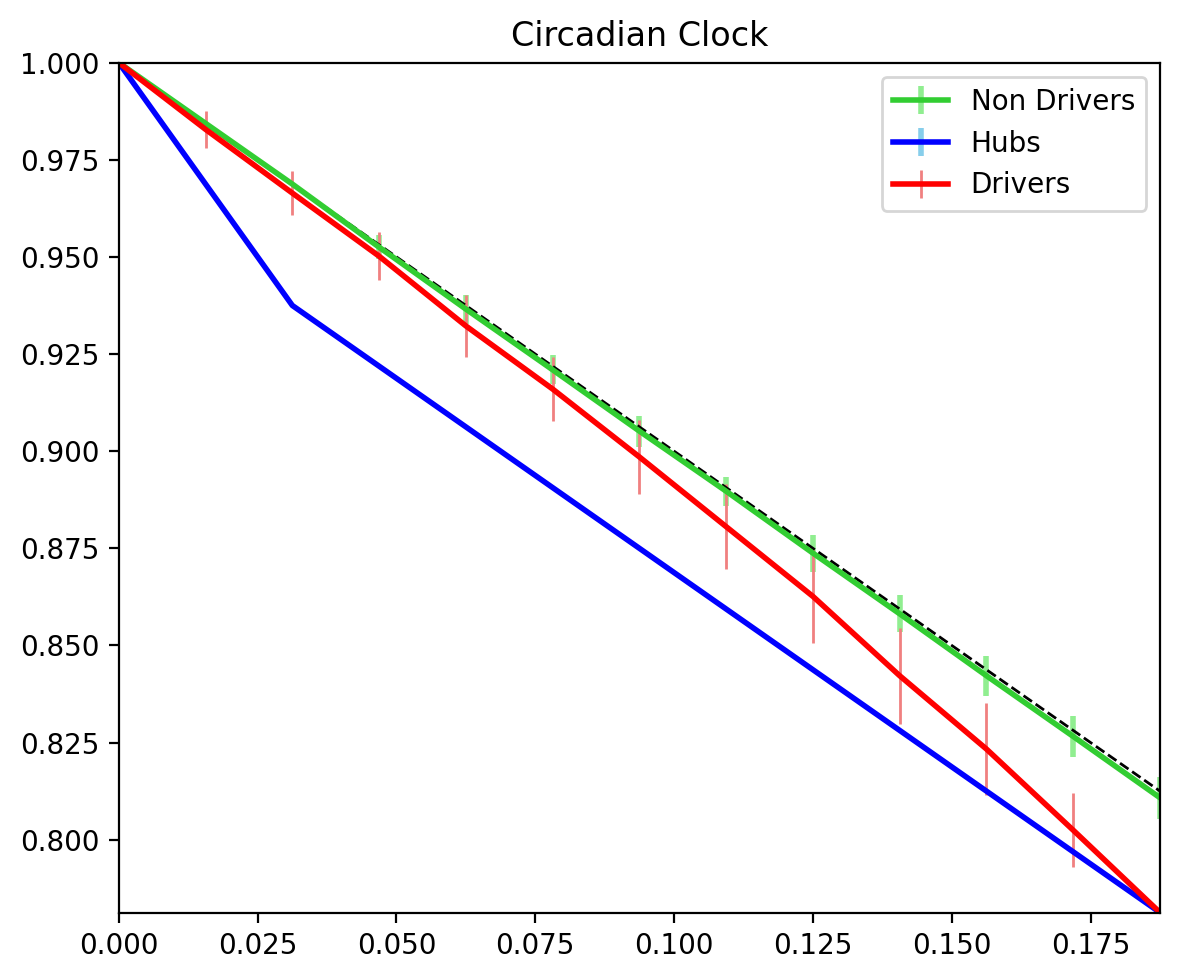

In [13]:
for name in targetPathways:
    obj=superPathwaysObjs[name]
    pathN=obj.networkLCC
    pathN.name = name
    print(nx.info(pathN))
    listOfDrivers=obj.drivers
    print('listOfDrivers: ',len(listOfDrivers))

    # fmax (how many node will be removed)
    fmax = len(listOfDrivers)

    N= pathN.number_of_nodes()
    fPerccent=fmax/N

    #Plotting    
    plt.figure(figsize=(6,5),dpi=200)
    
    plotRandomAttack(pathN,fmax)
    plotHubAttack(pathN,fmax)
    plotDriverAttack(pathN,listOfDrivers)    
    

    plt.plot([0, fPerccent], [1,1-fPerccent], 'k--',linewidth=1)
    plt.margins(x=0)
    plt.margins(y=0)
    if(name == 'ReactomeFI_LCC_AllSuperPathways'):
        plt.title('All Super Pathways')
    else:    
        plt.title(pathN.name)
    plt.legend()
    plt.tight_layout()
    plt.savefig("./4 imgs/CC/"+obj.name+" - CC.png", format='png', dpi=800)
    plt.savefig("./4 imgs/CC/"+obj.name+" - CC.svg", format='svg')
    plt.show()  
    plt.close()
    
    break#Remove this break. Its is here just to show the first plot on GitHub